# Deep Q-Networks (DQN)

For this notebook, we'll be following along with the PyTorch tutorial https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html to train a DQN agent to control a cartpole from OpenAI's Gym: CartPole-v0 environment.

### Packages:
`gym`: Reinforcement learning environment


__Torch packages__
- `torch.nn`: Neural networks
- `torch.optim`: Optimization
- `torch.autograd`: Automatic differentiation of scalar valued functions
- `torch.nn.functional`: Contains basic blocks of layers for building networks
- `torchvision.transforms`: 

In [2]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Build the environment.

In [3]:
env = gym.make('CartPole-v0').unwrapped

## Replay Memory

Experience replay memory stores observed state transitions (agent's experience) for later access. Random sampling from replay memory decorrelates batches (stabilizes & improves training process)
- `Transition`: (named tuple) Represents single transition in environment. Maps (state, action) pairs to the resulting (next_state, reward)--state is screen difference image.
- `ReplayMemory`: Cyclic buffer with fixed size to hold recent observations. Uses `.sample()` to select random batch of transitions for training
 - Buffer: Region of physical memory to store data temporarily as it moves through processes
 - Cyclic buffer: More appropriate as a first-in-first-out (FIFO) buffer than standard buffers (LIFO)

In [4]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## Q-Network

$\delta = Q(s,a) - (r + \gamma maxQ(s^\prime,a))$
- Temporal difference error $\delta$
- Minimize error with `Huber loss` (Mean squared error when error small, mean absolute error when error large)
  - More robust for noisy estimates of $Q$
  - Calculate this over a batch of transitions, $B$, sampled from replay memory:
  
\begin{align}\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)\end{align}

\begin{align}\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
     \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
     |\delta| - \frac{1}{2} & \text{otherwise.}
   \end{cases}\end{align}

Using a convolutional neural network (CNN) that observes the difference between the current and previous screen patches. Two outputs $Q_{(s,left)}$ and $Q_{(s,right)}$ to predict the expected reward from taking either action given the current input

`nn.Conv2d`: Applies 2D convolution over input signal made of more than one input plane

- `in_channels`(*int*): # of channels in input image
- `out_channels`(*int*): # of channels produced by convolution
- `kernel_size`(*int* or *tuple*): Size of convolving filter
- `stride`(*int* or *tuple*): # of pixels kernel moves horizontally & vertically across input planes when creating feature map

Because this is a 2D convolution, for `kernel_size` and `stride`:
- single `int`: Uses this value for both the height and width
- `tuple` of two `ints`: First value is height, second is width
   
`linear_input_size` determines the size of the input that the first layer accepts, calculated

*\**Note: In Deep Q-Networks, *

In [177]:
class DQN(nn.Module):
    
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        
        def conv2d_size_out(size, kernel_size=5, stride=2):
            return(size - (kernel_size - 1) - 1) // stride + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)
        
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))
    
dqn = DQN

## Extract Inputs

`torchvision`: Helps composing image transforms, displays example patch of what it extracted once cell is run

`get_screen()`: (method) Grabs screen size of gym's render of environment
- Reorders values to the way pytorch likes it (C = # of channels, H = height of screen, W = width of screen)
- Ignores top half of screen (cartpole in bottom half)


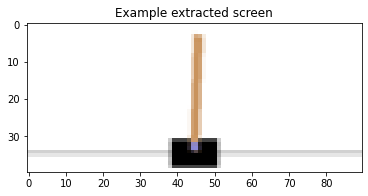

In [6]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)

env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

## Training

### Hyperparameters & Utilities 

Instantiates model & optimizer; defines utilities:



- `select_action`: Selects action according to epsilon greedy policy (simple exploration-exploitation policy)
 - most of the time, our agent will use (exploit) the model for choosing an action, but it will sometimes choose a uniform random sample (explore), and the chance of choosing a random action decays with each episode. Similar to humans playing games; frequency of pressing random buttons decreases every day we play the game because we learn which buttons do what we want them to do at given states of the game.
 - Probability of choosing random action starts at `EPS_START` & exponentially decays at a rate of `EPS_DECAY` towards end value `EPS_END`
- `plot_durations`: Helper for plotting durations of episodes & average over last 100 episodes (measure from official evals)
 - Plot under cell with main training loop & updates after every episode
 
 - `target_net`: Model's target network. A target network is a duplicate of the estimated value function that is held fixed for some number of steps in each run.
 - Target networks work to mitigate the unstable learning process inherent in Q-learning.

In [45]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

episode_durations = []

def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=False)
        display.display(plt.gcf())
    
    print("total reward: ", total_reward, "max reward is ", max_reward, "from episode ", max_reward_ep)

### Training Loop

`optimize_model`: Function that performs a single step of the optimization

1. Sample a batch
2. Concatenate all tensors into single tensor
3. Compute:
    - The quality of the action it did at the state it was at $Q(s_t,a_t)$
    - The resulting value of the new state $V(s_{t+1}) = max_aQ(s_{t+1},a)$
4. Combine the quality of the state-action pair $Q$ & the current reward value $V$ to form the model's loss value
    - If $s$ is terminal state, meaning the pole fell, then $V(s) = 0$
    - Use target network to compute $V(s_{t+1})$ for stability
    - Target weights constant most of the time, occasionally updates policy network's weights (usually set number, but using episodes)

In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

#### Training Loop

`num_episodes`: Set small, should download notebook & run lot more episodes, such as 300+ for meaningful duration improvements

1. Reset environment & initialize `state` tensor
2. Sample action
3. Execute action
4. Observe next screen & reward +1
 - When model fails, episode ends
 - Restart loop

In [46]:
num_episodes = 300
max_reward = 0
max_reward_ep = 0
reward_history = []
ep_history = []

for i_episode in range(num_episodes):
    print("episode: ", i_episode)
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    total_reward = 0
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        total_reward += reward
        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            
            reward_history = np.append(reward_history, total_reward)
            max_reward = np.max(reward_history)
            max_reward_ep = np.argmax(reward_history)
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

<Figure size 432x288 with 0 Axes>

total reward:  tensor([51.]) max reward is  258.0 from episode  82
Complete


<Figure size 432x288 with 0 Axes>

In [188]:
f"The max reward was {max_reward} from episode {max_reward_ep}, after {i_episode + 1} episodes"

'The max reward was 258.0 from episode 82, after 300 episodes'

## Saving & Loading modules

A PyTorch module's state is identified with its own `state_dict`, which contains all of its parameters (weights and biases) and buffers. We can save our trained models, which we created as a `torch.nn.Module`, as PyTorch .pt or .pth files with `torch.save()`. By saving the state_dict instead of the module, we don't have to worry about compatibility or overwriting our module when we want to change or reuse it. 

In [145]:
# Store DQN policy & target networks from week 9 for the Cartpole problem
dqnC_p_F9 = policy_net # Policy network
dqnC_t_F9 = target_net  # Target network

# Store the policy & target networks' state dict to some variables
dqnC_p_F9_sd = dqnC_p_F9.state_dict()
dqnC_t_F9_sd = dqnC_t_F9.state_dict()

# View the weights and biases of the policy and target networks' layers
print("Policy: ", dqnC_p_F9_sd)
print("Target: ", dqnC_t_F9_sd)

Policy:  OrderedDict([('conv1.weight', tensor([[[[-1.5538e-03,  1.2067e-01,  8.8024e-01, -3.9381e-01,  8.2007e-01],
          [ 2.2906e+00, -1.6334e+00,  6.1205e-03, -1.4980e+00, -2.0047e+00],
          [ 9.0410e-01,  8.3875e-01,  1.4089e-01,  1.2972e+00,  7.0045e-02],
          [ 5.0186e-01, -1.1138e+00, -2.0296e+00,  4.6675e-01,  1.6448e+00],
          [-7.0147e-01,  4.8479e-01,  1.5327e+00, -6.5602e-01, -1.8451e+00]],

         [[ 6.6979e-01,  3.1604e-01,  8.5163e-01, -1.3380e+00,  8.8792e-01],
          [ 1.2416e+00, -1.3262e+00,  5.8653e-01, -1.5715e+00, -1.7189e+00],
          [ 3.3881e-01,  2.9200e-01, -4.1584e-02,  1.4301e+00,  1.1320e+00],
          [-2.9955e-01, -8.1845e-01, -1.6323e+00,  1.1006e+00,  2.3567e+00],
          [-1.1951e+00,  9.7688e-01,  1.4055e+00, -6.2990e-01, -1.7679e+00]],

         [[ 8.5072e-01,  2.5493e-01,  8.9687e-01, -1.4964e+00,  8.6812e-01],
          [ 9.9831e-01, -1.7835e+00,  3.8072e-01, -1.2554e+00, -1.2678e+00],
          [ 3.1327e-01,  3.8259e-

In [143]:
# Save the state_dict of the networks to a PyTorch file
torch.save(dqnC_p_F9.state_dict(), 'dqnC_p_F9.pt')
torch.save(dqnC_t_F9.state_dict(), 'dqnC_t_F9.pt')

When we want to load our module again, we first use `torch.load()` to load the module's state_dict from the PyTorch .pt or .pth file, then `load_state_dict()` to restore the state of the module that we saved to our new modules.

In [144]:
# Load the state_dict of the networks from the PyTorch file into some new variables
new_dqnC_p_sd = torch.load('dqnC_p_F9.pt')
new_dqnC_t_sd = torch.load('dqnC_t_F9.pt')

In [141]:
# Instantiate new DQN modules
new_dqnC_p = DQN(screen_height, screen_width, n_actions).to(device)
new_dqnC_t = DQN(screen_height, screen_width, n_actions).to(device)

# Load the state_dict into the new DQN modules
new_dqnC_p.load_state_dict(new_dqnC_p_sd)
new_dqnC_t.load_state_dict(new_dqnC_t_sd)

print(new_dqnC_p.state_dict())
print(new_dqnC_t.state_dict())

OrderedDict([('conv1.weight', tensor([[[[-1.5538e-03,  1.2067e-01,  8.8024e-01, -3.9381e-01,  8.2007e-01],
          [ 2.2906e+00, -1.6334e+00,  6.1205e-03, -1.4980e+00, -2.0047e+00],
          [ 9.0410e-01,  8.3875e-01,  1.4089e-01,  1.2972e+00,  7.0045e-02],
          [ 5.0186e-01, -1.1138e+00, -2.0296e+00,  4.6675e-01,  1.6448e+00],
          [-7.0147e-01,  4.8479e-01,  1.5327e+00, -6.5602e-01, -1.8451e+00]],

         [[ 6.6979e-01,  3.1604e-01,  8.5163e-01, -1.3380e+00,  8.8792e-01],
          [ 1.2416e+00, -1.3262e+00,  5.8653e-01, -1.5715e+00, -1.7189e+00],
          [ 3.3881e-01,  2.9200e-01, -4.1584e-02,  1.4301e+00,  1.1320e+00],
          [-2.9955e-01, -8.1845e-01, -1.6323e+00,  1.1006e+00,  2.3567e+00],
          [-1.1951e+00,  9.7688e-01,  1.4055e+00, -6.2990e-01, -1.7679e+00]],

         [[ 8.5072e-01,  2.5493e-01,  8.9687e-01, -1.4964e+00,  8.6812e-01],
          [ 9.9831e-01, -1.7835e+00,  3.8072e-01, -1.2554e+00, -1.2678e+00],
          [ 3.1327e-01,  3.8259e-01,  2.93